# Example 2. Alloying elements in recycling.

A recycling system with two end-of-life (EoL) products, two scrap types, one secondary material, and several types of losses are studied. Three chemical elements are considered: iron, copper, and manganese. A time horizon of 30 years [1980-2010], five processes, and time-dependent parameters are analysed. The processes have element-specific yield factors, meaning that the loss rates depend on the chemical element considered. These values are given below.

The research questions are:

* How much copper accumulates in the secondary steel assuming that all available scrap is remelted?
* How much manganese is lost in the remelting process assuming that all available scrap is remelted?
* What is more effective in reducing the copper concentraction of secondary steel: A reduction of the shredding yield factor for copper from EoL machines into steel scrap of 25% or an increase in the EoL buildings flow by 25%? (All other variables and parameters remaining equal)

<img src="pictures/SteelAlloyElementsWasteMgt.png" width="554" height="490" alt="Simple MFA system">

The model equations are as follows:
* $F_{1\_3}(t,e) = \Gamma_1(e) \cdot F_{0\_1}(t,e) $ (shredder yield factor)
* $F_{1\_0}(t,e) = (1 - \Gamma_1(e)) \cdot F_{0\_1}(t,e) $ (mass balance)

* $F_{2\_3}(t,e) = \Gamma_2(e) \cdot F_{0\_2}(t,e) $ (demolition yield factor)
* $F_{2\_4}(t,e) = (1 - \Gamma_2(e)) \cdot F_{0\_2}(t,e) $ (mass balance)

* $F_{3\_0}(t,e) = \Gamma_3(e) \cdot (F_{1\_3}(t,e)+F_{2\_3}(t,e)) $ (remelting yield factor)
* $F_{3\_5}(t,e) = (1 - \Gamma_3(e)) \cdot (F_{1\_3}(t,e)+F_{2\_3}(t,e)) $ (mass balance)

Here the index letters t denote the model time and e the chemical element.

## 1. Load sodym and other useful packages

In [1]:
from copy import copy, deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sodym.data_reader import DataReader
from sodym import (
    DimensionDefinition, Dimension, DimensionSet, ParameterDefinition, Parameter, Process, FlowDefinition, Flow, StockDefinition, MFASystem, NamedDimArray
)
from sodym.flow_helper import make_empty_flows
from sodym.stock_helper import make_empty_stocks
from sodym.flow_naming import process_names_with_arrow
from sodym.export.helper import ArrayPlotter

## 2. Define the data requirements, flows, stocks and MFA system equations

We define the dimensions that are relevant for our system and the model parameters, processes, stocks and flows. We further define a class with our system equations in the compute method.

In [2]:
dimension_definitions = [
    DimensionDefinition(letter='t', name='Time', dtype=int),
    DimensionDefinition(letter='e', name='Material', dtype=str)
]

parameter_definitions = [
    ParameterDefinition(name='eol machines', dim_letters=('t', )),
    ParameterDefinition(name='eol buildings', dim_letters=('t', )),
    ParameterDefinition(name='composition eol machines', dim_letters=('e', )),
    ParameterDefinition(name='composition eol buildings', dim_letters=('e', )),
    ParameterDefinition(name='shredder yield', dim_letters=('e', )),
    ParameterDefinition(name='demolition yield', dim_letters=('e', )),
    ParameterDefinition(name='remelting yield', dim_letters=('e', )),
]

In [3]:
process_names = ['sysenv', 'shredder', 'demolition', 'remelting', 'landfills', 'slag piles']
processes = {name: Process(name=name, id=index) for index, name in enumerate(process_names)}

In [4]:
flow_definitions = [
    FlowDefinition(from_process_name='sysenv', to_process_name='shredder', dim_letters=('t', 'e')),
    FlowDefinition(from_process_name='sysenv', to_process_name='demolition', dim_letters=('t', 'e')),
    FlowDefinition(from_process_name='shredder', to_process_name='remelting', dim_letters=('t', 'e')),  # scrap type 1
    FlowDefinition(from_process_name='shredder', to_process_name='sysenv', dim_letters=('t', 'e')),  # shredder residue
    FlowDefinition(from_process_name='demolition', to_process_name='remelting', dim_letters=('t', 'e')),  # scrap type 2
    FlowDefinition(from_process_name='demolition', to_process_name='landfills', dim_letters=('t', 'e')),  # loss
    FlowDefinition(from_process_name='remelting', to_process_name='slag piles', dim_letters=('t', 'e')),  # secondary steel
    FlowDefinition(from_process_name='remelting', to_process_name='sysenv', dim_letters=('t', 'e')),  # slag
]

In [5]:
stock_definitions = [
    StockDefinition(name='landfills', process='landfills', dim_letters=('t', 'e'),),
    StockDefinition(name='slag piles', process='slag piles', dim_letters=('t', 'e'),),
]


We just need to define the compute method with our system equations, as all the other things we need are inherited from the MFASystem class.  The flow names are generated from the processes each flow connects, in this case with the naming function `process_names_with_arrow`, which is passed to the flow initialization below.

In [6]:
class SimpleMFA(MFASystem):
    def compute(self):
        self.flows['sysenv => shredder'][...] = self.parameters['eol machines'] * self.parameters['composition eol machines']
        self.flows['sysenv => demolition'][...] = self.parameters['eol buildings'] * self.parameters['composition eol buildings']
        self.flows['shredder => remelting'][...] = self.flows['sysenv => shredder'] * self.parameters['shredder yield']
        self.flows['shredder => sysenv'][...] = self.flows['sysenv => shredder'] * (1 - self.parameters['shredder yield'])
        self.flows['demolition => remelting'][...] = self.flows['sysenv => demolition'] * self.parameters['demolition yield']
        self.flows['demolition => landfills'][...] = self.flows['sysenv => demolition'] * (1 - self.parameters['demolition yield'])
        self.flows['remelting => sysenv'][...] = (
            self.flows['shredder => remelting'] + self.flows['demolition => remelting']) * self.parameters['remelting yield']
        self.flows['remelting => slag piles'][...] = (
            self.flows['shredder => remelting'] + self.flows['demolition => remelting']) * (1 - self.parameters['remelting yield'])
        self.stocks['landfills'].inflow[...] = self.flows['demolition => landfills']
        self.stocks['landfills'].compute()
        self.stocks['slag piles'].inflow[...] = self.flows['shredder => remelting']
        self.stocks['slag piles'].compute()


## 3. Load data and initialise flows and stocks
Now that we have defined the MFA system and know what data we need, we can load the data.
Even though this is only a small system, we will load the data from excel files, as an example for more complex systems with larger datasets. To do this data loading, we define a DataReader class. Such a class can be reused with different datasets of the same format by passing attributes, e.g. data paths, in the init function.

The methods `read_dimensions` and `read_parameters` are already defined in the parent DataReader class, and loop over the methods `read_dimension` and `read_parameter_values` that we specify for our usecase here.

In [7]:
class CustomDataReader(DataReader):

    def __init__(self, path_to_time_parameters, path_to_element_parameters):
        self.time_parameters = pd.read_excel(path_to_time_parameters, index_col=0)
        self.element_parameters = pd.read_excel(path_to_element_parameters, index_col=0)

    def read_dimension(self, dimension_definition: DimensionDefinition) -> Dimension:
        if dimension_definition.letter == 't':
            data = list(self.time_parameters.index)
        elif dimension_definition.letter == 'e':
            data = list(self.element_parameters.index)
        return Dimension(name=dimension_definition.name, letter=dimension_definition.letter, items=data)

    def read_parameter_values(self, parameter: str, dims: DimensionSet) -> Parameter:
        if dims.letters == ('t', ):
            data = self.time_parameters[parameter].values
        elif dims.letters == ('e', ):
            data = self.element_parameters[parameter].values
        return Parameter(dims=dims, values=data)

In [8]:
data_reader = CustomDataReader(
    path_to_time_parameters='example2_temporal_parameters.xlsx',
    path_to_element_parameters='example2_material_parameters.xlsx'
)
dimensions = data_reader.read_dimensions(dimension_definitions)
parameters = data_reader.read_parameters(parameter_definitions, dims=dimensions)

In [9]:
flows = make_empty_flows(processes=processes, flow_definitions=flow_definitions, dims=dimensions,
                         naming=process_names_with_arrow)

In [10]:
stocks = make_empty_stocks(stock_definitions, dims=dimensions, processes=processes)  # flow-driven stock objects

## 4. Put the pieces together
Create a SimpleMFA instance by passing the loaded dimension and parameter data, as well as the initialised flow and stock objects. Solve the system equations by running the `compute` method.

In [11]:
mfa_example = SimpleMFA(dims=dimensions, processes=processes, parameters=parameters, flows=flows, stocks=stocks)
mfa_example.compute()

## 5. Results
Here we answer the research questions from the beginning of the notebook.

**How much copper accumulates in the secondary steel assuming that all available scrap is remelted?**

In [12]:
remelted = mfa_example.flows['remelting => sysenv']

Text(0.5, 0.98, 'Amount of copper and manganese in secondary steel')

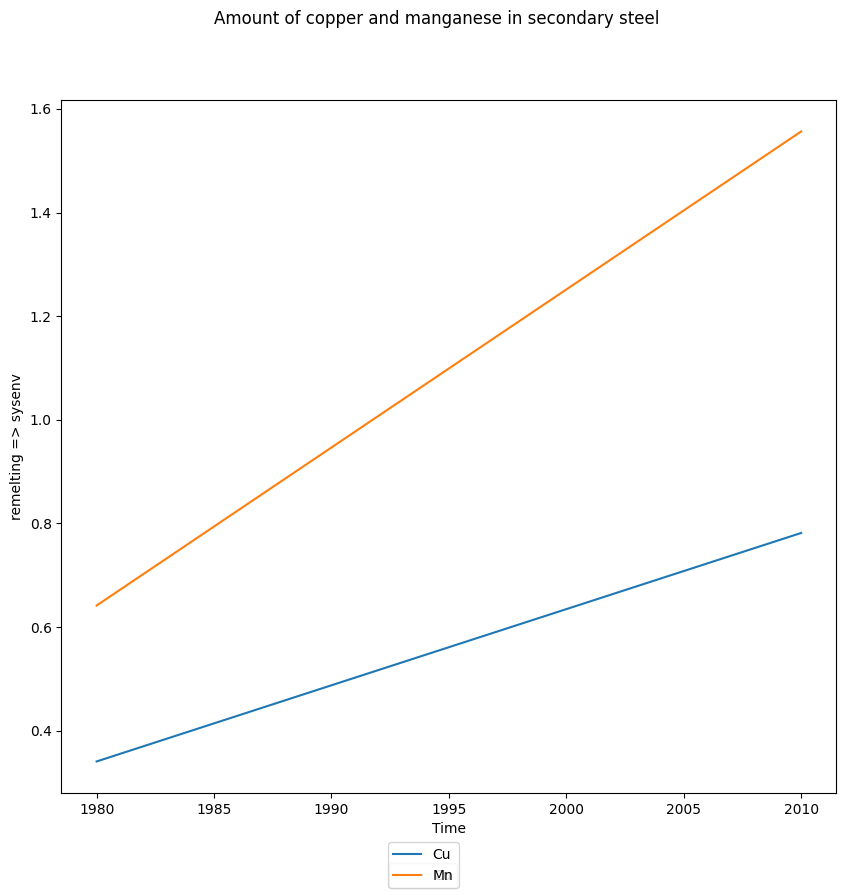

In [13]:
cu_plotter = ArrayPlotter(
    array=remelted['Cu'],
    intra_line_dim='Time',
    line_label='Cu')
fig, ax = cu_plotter.plot()
mn_plotter = ArrayPlotter(
    array=remelted['Mn'],
    intra_line_dim='Time',
    line_label='Mn',
    fig_ax=(fig, ax))
fig, ax = mn_plotter.plot()

fig.suptitle('Amount of copper and manganese in secondary steel')

Text(0.5, 0.98, 'Share of copper and manganese in secondary steel')

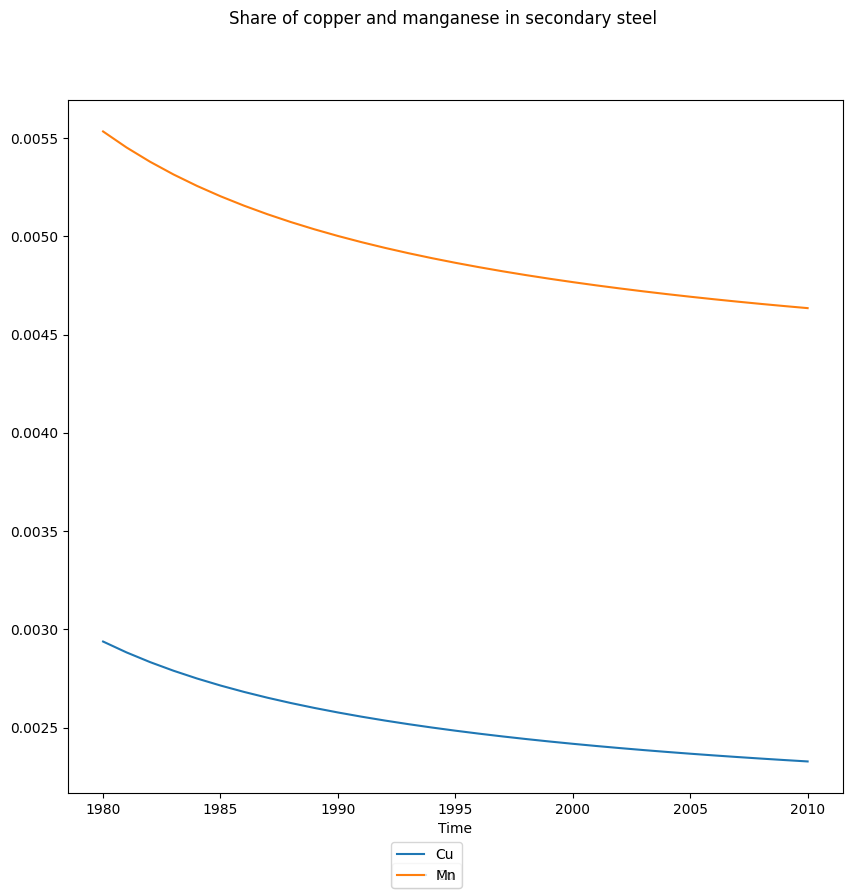

In [14]:
remelted_shares = NamedDimArray(dims=remelted.dims)
remelted_shares[...] = remelted / remelted.sum_nda_over(('e',))

cu_plotter = ArrayPlotter(
    array=remelted_shares['Cu'],
    intra_line_dim='Time',
    line_label='Cu')
fig, ax = cu_plotter.plot()
mn_plotter = ArrayPlotter(
    array=remelted_shares['Mn'],
    intra_line_dim='Time',
    line_label='Mn',
    fig_ax=(fig, ax))
fig, ax = mn_plotter.plot()

fig.suptitle('Share of copper and manganese in secondary steel')

The copper flow in the secondary steel increases linearly from 0.34 kt/yr in 1980 to 0.78 kt/yr in 2010. The concentration of copper declines in a hyperbolic curve from 0.294% in 1980 to 0.233% in 2010.

That concentration is below 0.4% at all times, the latter being the treshold for construction grade steel, but above 0.04%, which is the threshold for automotive steel.

**How much manganese is lost in the remelting process assuming that all available scrap is remelted?**

Text(0.5, 0.98, 'Manganese lost in the remelting process')

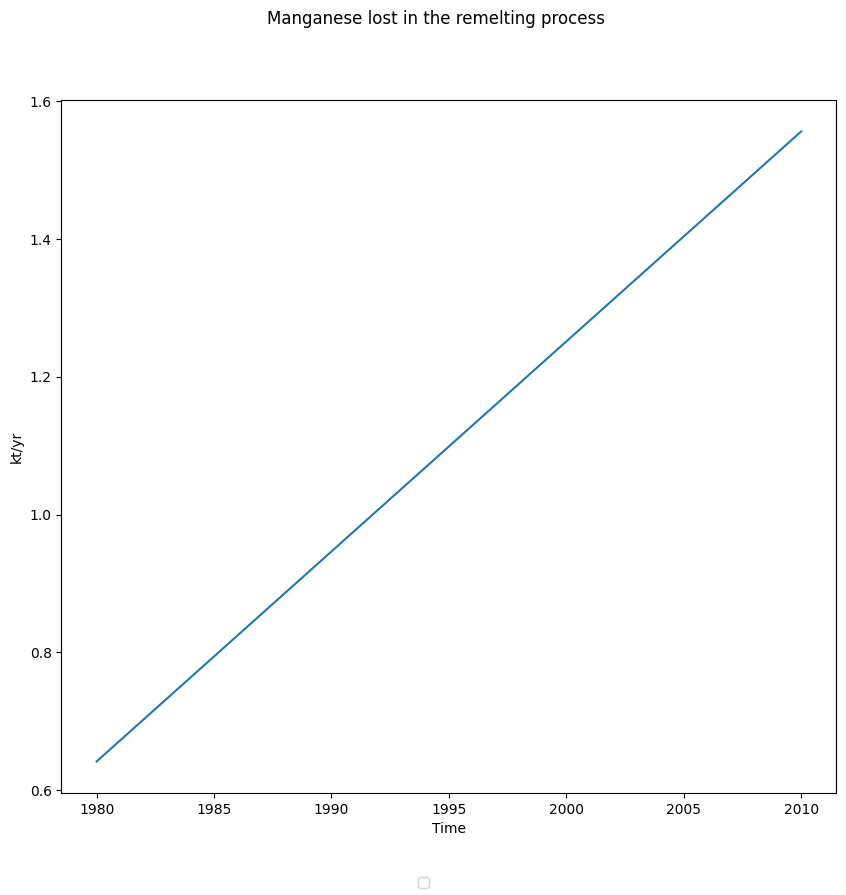

In [15]:
manganese_to_slag = mfa_example.flows['remelting => slag piles']['Mn']

plotter = ArrayPlotter(
    array=manganese_to_slag,
    intra_line_dim='Time',
    ylabel='kt/yr')
fig, ax = plotter.plot()

fig.suptitle('Manganese lost in the remelting process')

**What is more effective in reducing the copper concentraction of secondary steel: A reduction of the shredding yield factor for copper from EoL machines into steel scrap of 25% or an increase in the EoL buildings flow by 25%? (All other variables and parameters remaining equal)**

To answer this we change the parameter values and recalculate the entire system.
In case a, we update the shredder yield, and in case b we increase the EoL buildings flow.
We could load new datasets for the parameters, but since we are only changing one value, we will just update that value.


In [16]:
parameters_a = deepcopy(parameters)
parameters_a['shredder yield'].set_values(np.array([0.92, 0.075, 0.92]))

mfa_example_a = SimpleMFA(dims=dimensions, processes=processes, parameters=parameters_a, flows=deepcopy(flows), stocks=deepcopy(stocks))
mfa_example_a.compute()

In [17]:
parameters_b = deepcopy(parameters)
parameters_b['eol buildings'][...] = 1.25 * parameters_b['eol buildings']

mfa_example_b = SimpleMFA(dims=dimensions, processes=processes, parameters=parameters_b, flows=deepcopy(flows), stocks=deepcopy(stocks))
mfa_example_b.compute()

Text(0.5, 0.98, 'Material concentration in secondary steel')

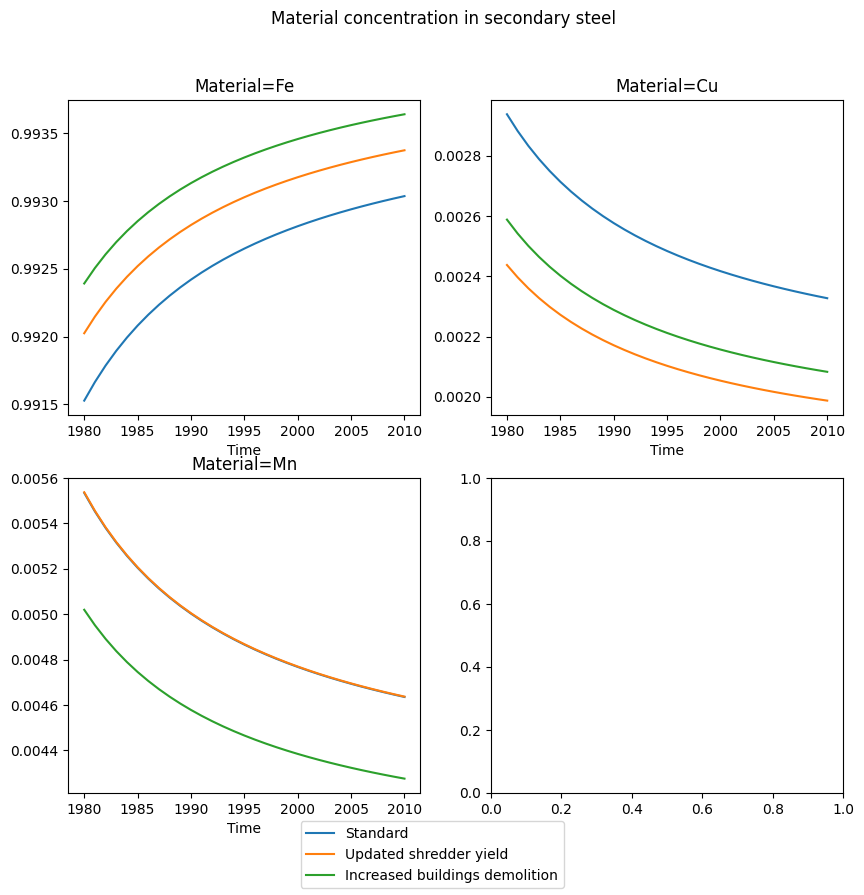

In [18]:
flow_a = mfa_example_a.flows['remelting => sysenv']
concentration_a = flow_a / flow_a.sum_nda_over(('e'))

flow_b = mfa_example_b.flows['remelting => sysenv']
concentration_b = flow_b / flow_b.sum_nda_over(('e'))

scenarios = Dimension(name='Scenarios', letter='s', items=['Standard', 'Updated shredder yield', 'Increased buildings demolition'])
new_dims = remelted_shares.dims.expand_by([scenarios])
concentrations = remelted_shares.cast_to(new_dims)
concentrations['Updated shredder yield'] = concentration_a
concentrations['Increased buildings demolition'] = concentration_b

plotter = ArrayPlotter(
    array=concentrations,
    intra_line_dim='Time',
    linecolor_dim='Scenarios',
    subplot_dim='Material')
fig, ax = plotter.plot()
fig.suptitle('Material concentration in secondary steel')

We can see that both measures reduce the copper concentration in the secondary steel. For the first year, the copper concentration is reduced from 0.294% to 0.244% if the Cu-yield into steel scrap of the shredder is reduced and to 0.259% if the EoL building flow treated is increased by 25%. The yield measure thus has a slightly higher impact on the copper contentration than the increase of a copper-poor scrap flow for dilution. In both cases the impact is not high enough to bring the copper concentration to values below 0.04%, which is necessary for automotive applications.